In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import stats

In [104]:
# Erdos-Renyi Network

def age_based_infection_rate(node_age, base_infection_rate):
    if 0 < node_age < 5:
        return 0.52  # Higher rate for children
    elif 4 < node_age < 10:
        return 0.41 
    elif 9< node_age < 15:
        return 0.14
    elif 14 < node_age < 20:
        return base_infection_rate
    else :
        return base_infection_rate


In [105]:
# Erdos-Renyi Network

def sir_model_er(N, i, r, k, initial_infected, timesteps, age, initial_age):
    # Create an Erdos-Renyi using nx
    # probability of edge formation
    p = k / (N - 1)  
    G = nx.fast_gnp_random_graph(N, p)

    # Assign ages to nodes based on the provided age distribution
    ages = {node: np.random.choice(age) for node in G.nodes()}
    prevalence_by_age = {age_group: [0] for age_group in initial_age.keys()}

    # Initialize the infection based on proportion 0.1
    # initial_infected_n = np.random.choice(G.nodes(), size=initial_infected, replace=False)
    # infected = set(initial_infected_n)

    infected = set()
    for age_group, fraction in initial_age.items():
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # size = min(int(fraction * initial_infected), len(age_group_nodes))
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)

    susceptible = set(G.nodes()) - infected
    recovered = set()
    
    # Record the prevalence over time
    S = [len(susceptible)]
    I = [len(infected)]
    R = [len(recovered)]
    prevalence = [len(infected) / N]
    infected_ages = []

    # Simulate the spread over time
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()

        # for node in set(infected):
        #     node_age = ages[node]
        #     # Apply age-based infection rate only at the initial infection
        #     if node in initial_infected_n:
        #         age_i = age_based_infection_rate(node_age, i)
        #     else:
        #         age_i = i

        for node in set(infected):
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)
        
        for age_group in initial_age.keys():
            infected_in_age_group = sum(1 for node in infected if age_group[0] <= ages[node] <= age_group[1])
            prevalence_by_age[age_group].append(infected_in_age_group / N)

        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected
        # infected_ages.append([ages[node] for node in infected])
        new_infected_ages = [ages[node] for node in new_infected]
        infected_ages.append(new_infected_ages)

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        prevalence.append(len(infected) / N)

    return S, I, R, prevalence, infected_ages, prevalence_by_age


In [116]:
# Parameters
N = 100000
initial_infected_fraction = 0.5
timesteps = 20
initial_infected = int(N * initial_infected_fraction)
immune_count = 0.5
immune_rate = 0.05
# Number of simulations to average over 
simulations = 30  
age = range(21) 

initial_age = {
    (0, 4): 0.2, 
    (5, 9): 0.2, 
    (10, 14): 0.2,
    (15, 20): 0.5
}

i_1 = 0.061
k_1 = 3.0
r = 0.9

In [117]:
prevalence_by_age_across_simulations = {age_group: [] for age_group in initial_age.keys()}

S, I, R, _ , infected_ages, _= sir_model_er(N, i_1, r, k_1, initial_infected, timesteps, age, initial_age)
prevalence = []
infected_ages = [age for ages in infected_ages for age in ages]

# add error bars to age distribution
std_infected_ages = np.std(infected_ages, axis=0)

for _ in range(simulations):
    _, _, _, preva_all, _, prevalence_by_age = sir_model_er(N, i_1, r, k_1, initial_infected, timesteps, age, initial_age)
    prevalence.append(preva_all)
    for age_group in initial_age.keys():
        prevalence_by_age_across_simulations[age_group].append(prevalence_by_age[age_group])

avg_prevalence = np.mean(prevalence, axis=0)
avg_prevalence_by_age = {age_group: np.mean(prevalence_by_age_across_simulations[age_group], axis=0) for age_group in initial_age.keys()}

# Add error bars to prevalence
std_prevalence = np.std(prevalence, axis=0)

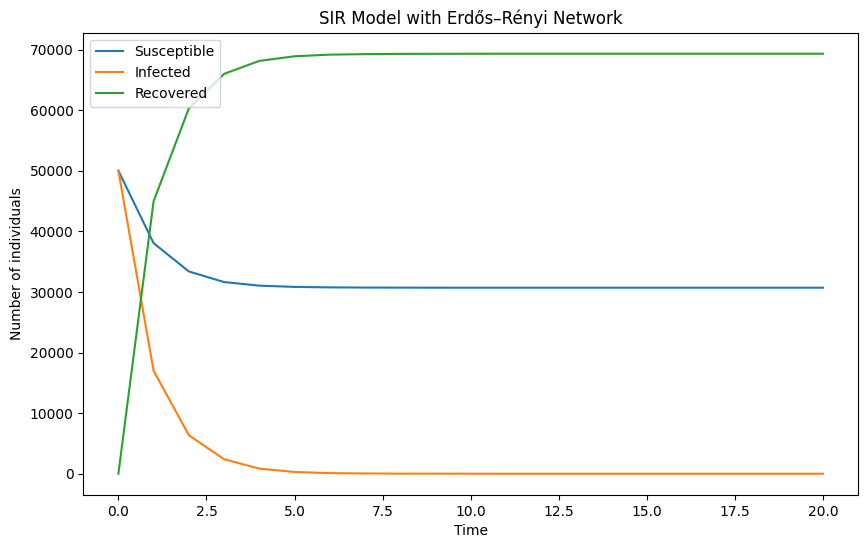

In [64]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIR Model with Erdős–Rényi Network')
plt.show()

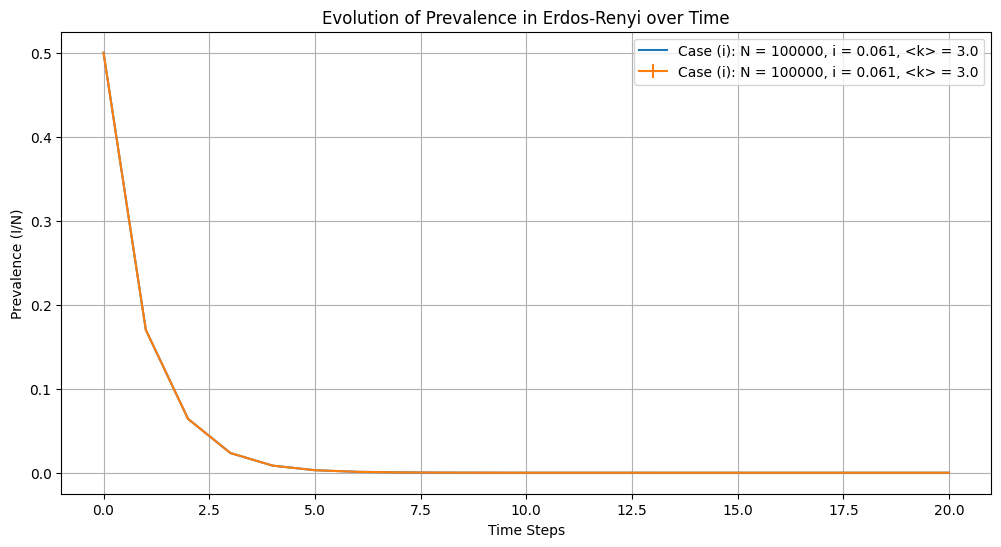

In [65]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(avg_prevalence, label=f'Case (i): N = {N}, i = {i_1}, <k> = {k_1}')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence (I/N)')
plt.errorbar(range(len(avg_prevalence)), avg_prevalence, yerr=std_prevalence, label=f'Case (i): N = {N}, i = {i_1}, <k> = {k_1}')
plt.title('Evolution of Prevalence in Erdos-Renyi over Time')
plt.legend()
plt.grid(True)
plt.show()

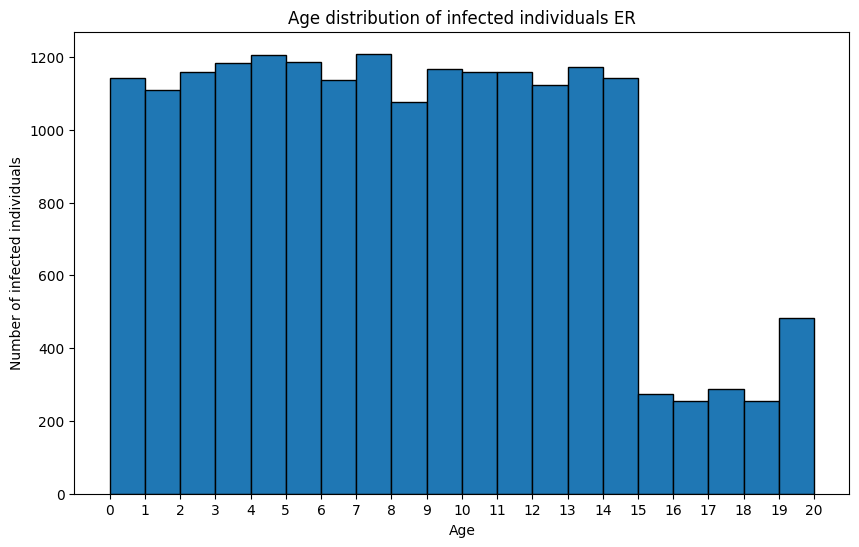

In [118]:
# Histogram of infected ages
plt.figure(figsize=(10, 6))
plt.hist(infected_ages, bins=range(21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals ER')
plt.xticks(range(21))
plt.show()

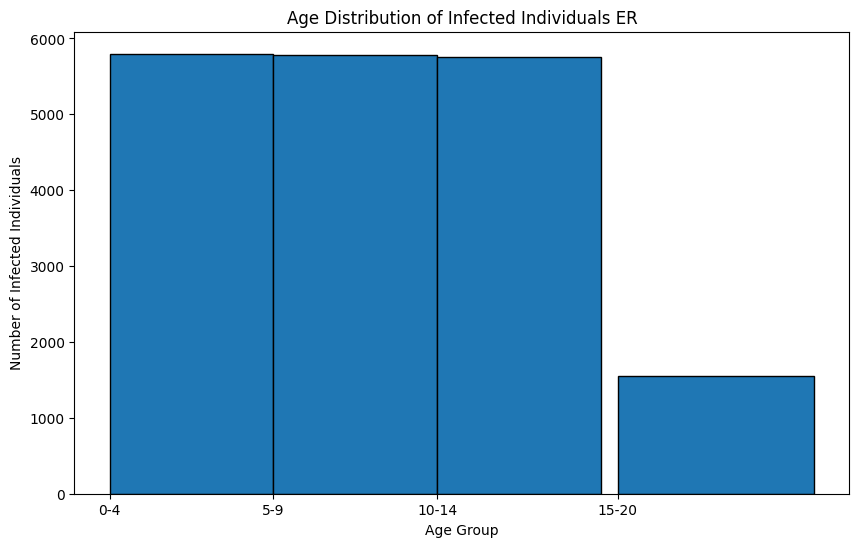

In [119]:
# Define age group bins for the histogram
age_bins = [0, 5, 10, 15, 21]  # 21 is the limit of the last bin (20+1)

# Calculate histogram of infected ages with the new bins
counts, bin_edges = np.histogram(infected_ages, bins=age_bins)

# Calculate the bin centers from the bin edges
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot the histogram with the new bins
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=np.diff(age_bins), edgecolor='black', align='edge')
plt.xlabel('Age Group')
plt.ylabel('Number of Infected Individuals')
plt.title('Age Distribution of Infected Individuals ER')
plt.xticks(bin_centers, ['0-4', '5-9', '10-14', '15-20'])  # Set the x-ticks to represent age groups
plt.show()


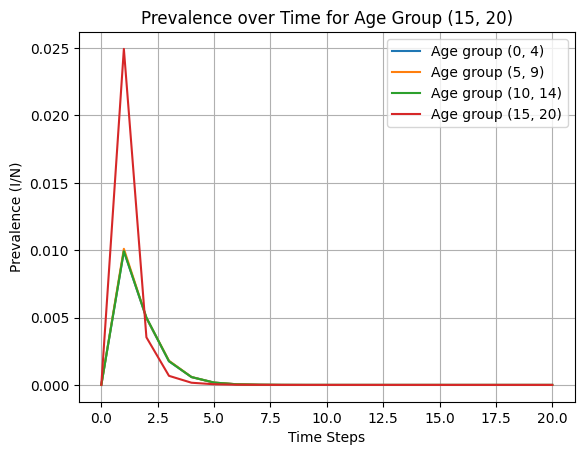

In [120]:
for age_group, prevalence in avg_prevalence_by_age.items():
    plt.plot(prevalence, label=f'Age group {age_group}')
    plt.xlabel('Time Steps')
    plt.ylabel('Prevalence (I/N)')
    plt.title(f'Prevalence over Time for Age Group {age_group}')
    plt.legend()
    plt.grid(True)

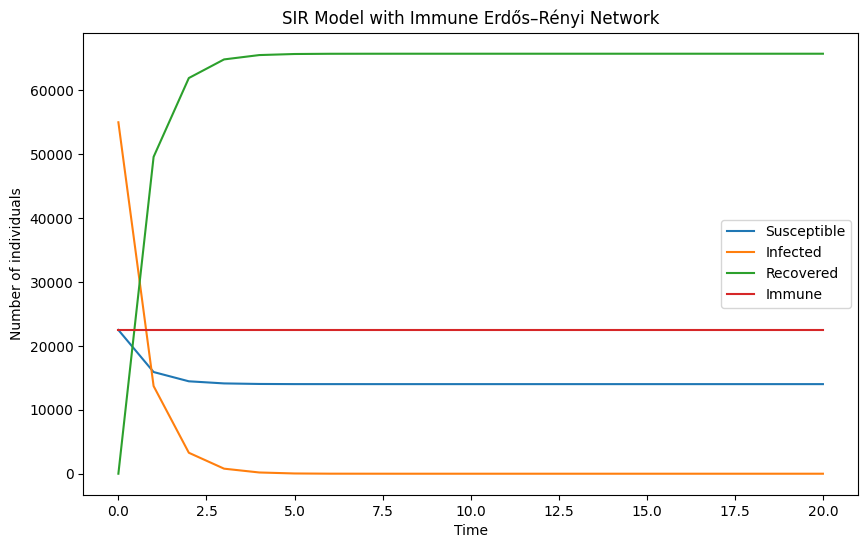

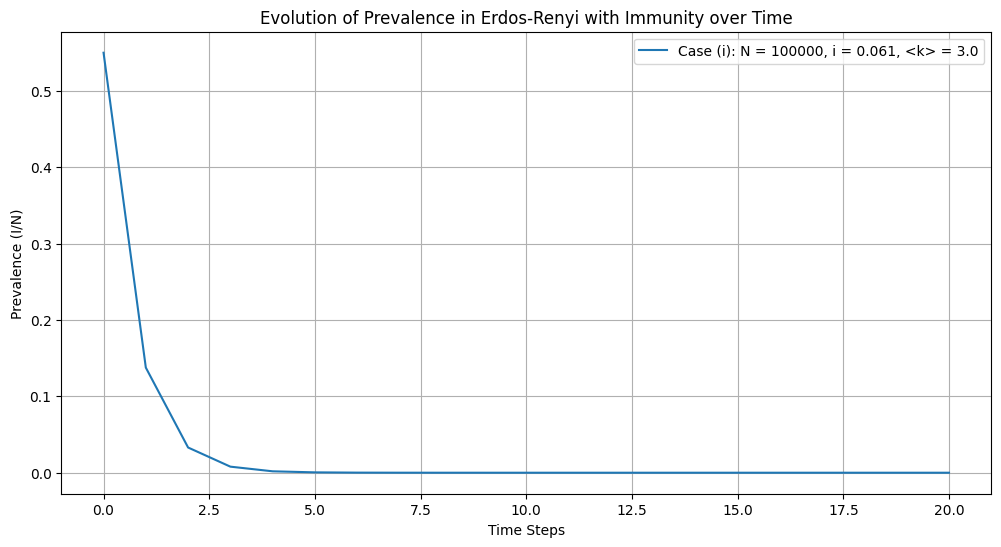

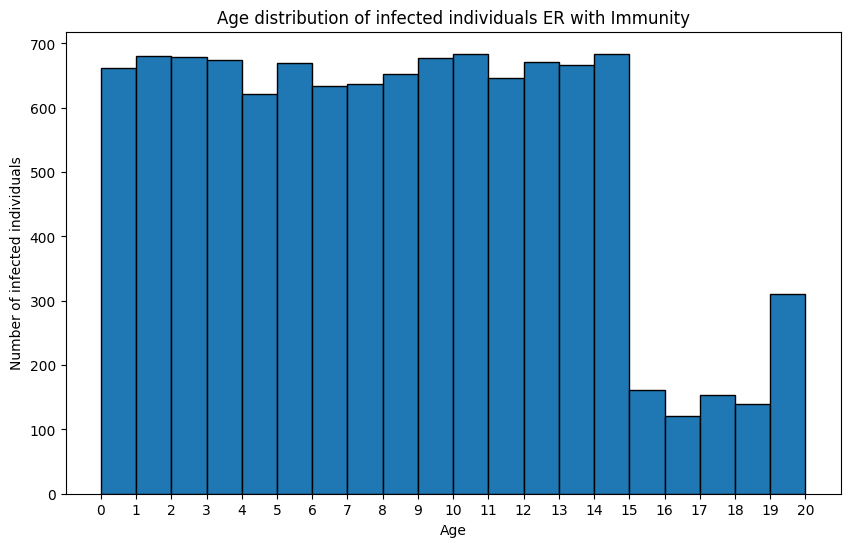

In [121]:
# Erdos-Renyi Network with Immunity

def Imm_er(N, i, r, k, initial_infected, timesteps, age, initial_age, immune_count, immune_rate):
    # Create an Erdos-Renyi using nx
    # probability of edge formation
    p = k / (N - 1)  
    G = nx.fast_gnp_random_graph(N, p)

    # Assign ages to nodes based on the provided age distribution
    ages = {node: np.random.choice(age) for node in G.nodes()}

    # Initialize the infection based on proportion 0.1
    # initial_infected_n = np.random.choice(G.nodes(), size=initial_infected, replace=False)
    # infected = set(initial_infected_n)

    infected = set()
    for age_group, fraction in initial_age.items():
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # size = min(int(fraction * initial_infected), len(age_group_nodes))
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)

    non_infected = set(G.nodes()) - infected
    Immune = set(np.random.choice(list(non_infected), size=int(len(non_infected)*immune_count), replace=False))    
    susceptible = non_infected - Immune
    recovered = set()
    
    # Record the prevalence over time
    S = [len(susceptible)]
    I = [len(infected)]
    R = [len(recovered)]
    IM = [len(Immune)]
    prevalence = [len(infected) / N]
    infected_ages = []

    # Simulate the spread over time
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()

        for node in set(infected):
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                elif neighbor in Immune and np.random.random() < immune_rate:
                    new_infected.add(neighbor)
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)

        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected
        # infected_ages.append([ages[node] for node in infected])
        new_infected_ages = [ages[node] for node in new_infected]
        infected_ages.append(new_infected_ages)

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        IM.append(len(Immune))
        prevalence.append(len(infected) / N)

    return S, I, R, IM, prevalence, infected_ages


SIm, IIm, RIm, IM, _ , infected_ages_Im= Imm_er(N, i_1, r, k_1, initial_infected, timesteps, age, initial_age, immune_count, immune_rate)
prevalence_Im = []
infected_ages_Im = [age for ages in infected_ages_Im for age in ages]

for _ in range(simulations):
    _, _, _, _, preva_all_Im, _ = Imm_er(N, i_1, r, k_1, initial_infected, timesteps, age, initial_age, immune_count, immune_rate)
    prevalence_Im.append(preva_all_Im)

avg_prevalence_Im = np.mean(prevalence_Im, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(SIm, label='Susceptible')
plt.plot(IIm, label='Infected')
plt.plot(RIm, label='Recovered')
plt.plot(IM, label='Immune')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIR Model with Immune Erdős–Rényi Network')
plt.show()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(avg_prevalence_Im, label=f'Case (i): N = {N}, i = {i_1}, <k> = {k_1}')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence (I/N)')
plt.title('Evolution of Prevalence in Erdos-Renyi with Immunity over Time')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(infected_ages_Im, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals ER with Immunity')
plt.xticks(range(0, 21))
plt.show()


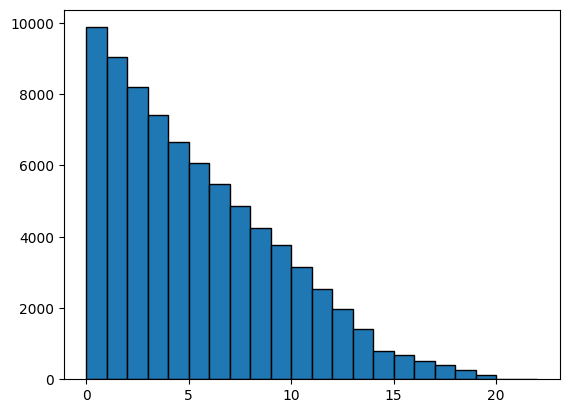

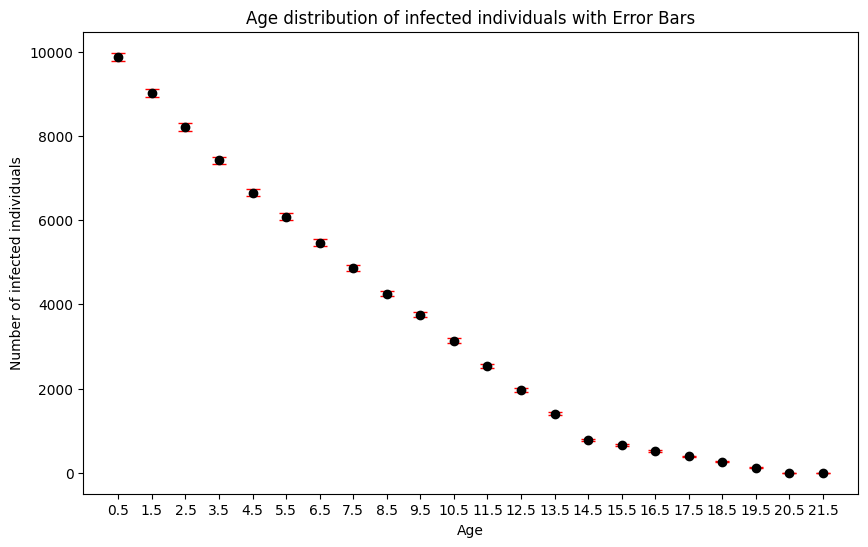

In [23]:
# Flatten the list of lists into a single list of ages for all simulations
all_infected_ages = [age for simulation in infected_ages_Im for age in range(simulation)]

# Calculate the histogram data
bin_edges = np.arange(0, 23)  # +2 to include the last age in the range
counts, _, _ = plt.hist(all_infected_ages, bins=bin_edges, edgecolor='black')

# Calculate the standard error (sqrt of counts) for each bin
stderr = np.sqrt(counts)

# Calculate the bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Create an error bar plot using the counts and their standard errors
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, counts, yerr=stderr, fmt='o', color='black', ecolor='red', capsize=5)
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals with Error Bars')
plt.xticks(bin_centers)
plt.show()

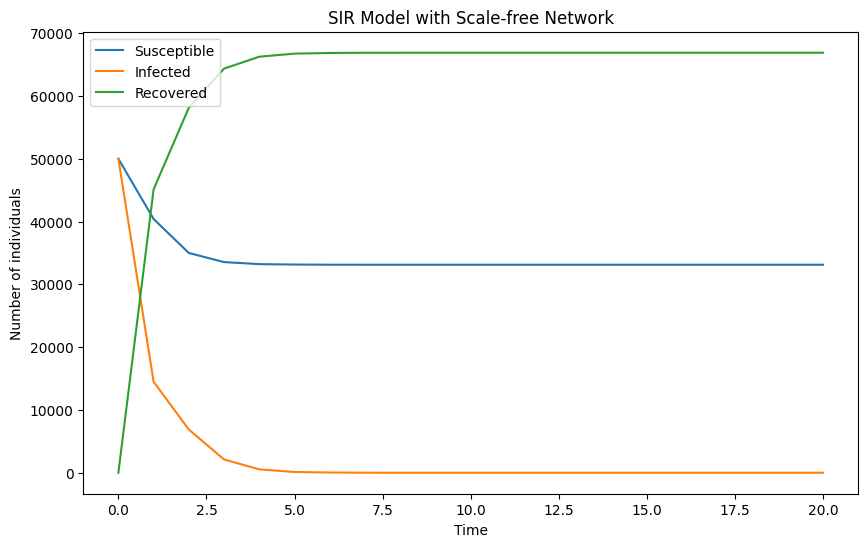

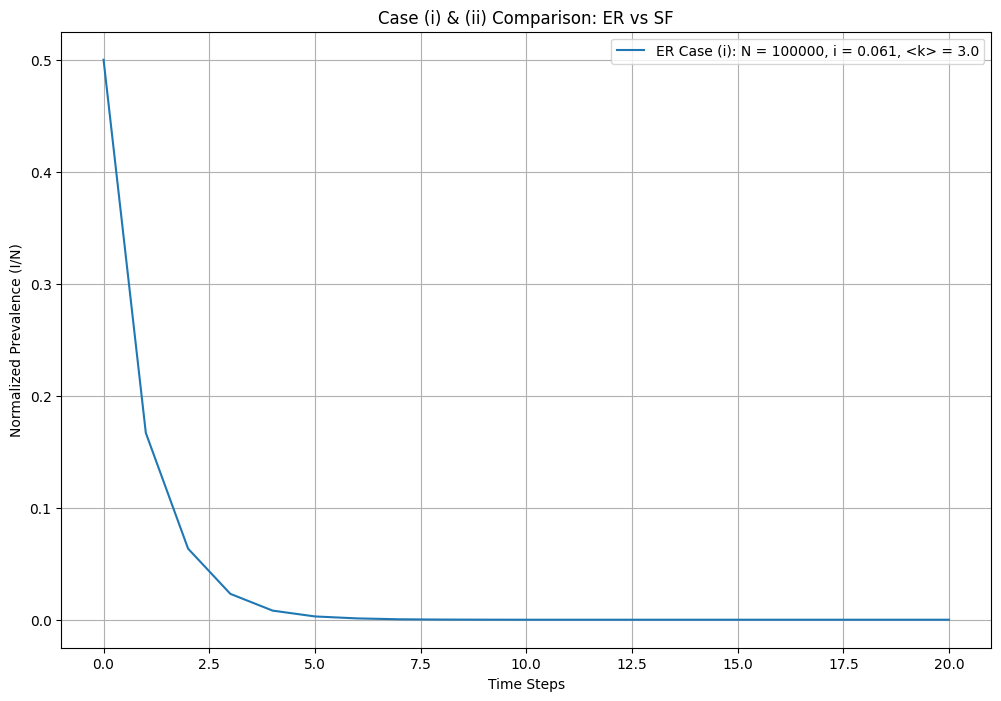

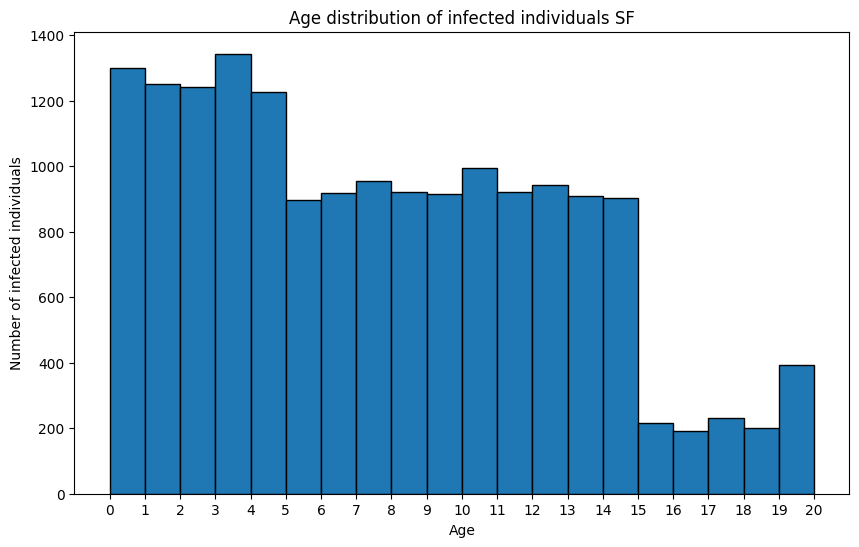

In [4]:
# Scale-free network

def sir_model_sf(N, i, k, initial_infected, timesteps, gamma, age, initial_age):
    # Generate a sequence of expected degrees with a power-law distribution
    s = nx.utils.powerlaw_sequence(N, gamma)
    # Rescale the expected degrees to match the given average degree
    s = np.array(s) * k / np.mean(s)
    # Generate the scale-free network
    G = nx.expected_degree_graph(s, selfloops=False)

    ages = {node: np.random.choice(age) for node in G.nodes()}

    # Initialize the infection
    # initial_infected = np.random.choice(G.nodes(), size=int(N * initial_infected_fraction), replace=False)
    
    infected = set()
    for age_group, fraction in initial_age.items():
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # size = min(int(fraction * initial_infected), len(age_group_nodes))
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)

    susceptible = set(G.nodes()) - infected
    recovered = set()
    
    # Record the prevalence over time
    S = [len(susceptible)]
    I = [len(infected)]
    R = [len(recovered)]
    prevalence = [len(infected) / N]
    infected_ages = []

    # Simulate the spread over time
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()
        
        for node in set(infected):
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)
                
        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        prevalence.append(len(infected) / N)
        new_infected_ages = [ages[node] for node in new_infected]
        infected_ages.append(new_infected_ages)

    return S, I, R, prevalence, infected_ages

# Parameters for the simulations
gamma = 2.5

# Run simulations for the scale-free network for case (i)
Sf, If, Rf, _, i_age = sir_model_sf(N, i_1, k_1, initial_infected, timesteps, gamma, age, initial_age)
prevalence_sf = []
i_age = [age for ages in i_age for age in ages]

for _ in range(simulations):
    _, _, _, preva_sf, _ = sir_model_sf(N, i_1, k_1, initial_infected, timesteps, gamma, age, initial_age)
    prevalence_sf.append(preva_all)

avg_prevalence_sf = np.mean(prevalence_sf, axis=0)

# Plot SIR
plt.figure(figsize=(10, 6))
plt.plot(Sf, label='Susceptible')
plt.plot(If, label='Infected')
plt.plot(Rf, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIR Model with Scale-free Network')
plt.show()

# Plotting the results for comparison
plt.figure(figsize=(12, 8))
plt.plot(avg_prevalence_sf, label=f'ER Case (i): N = {N}, i = {i_1}, <k> = {k_1}')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Prevalence (I/N)')
plt.title('Case (i) & (ii) Comparison: ER vs SF')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(i_age, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals SF')
plt.xticks(range(0, 21))
plt.show()


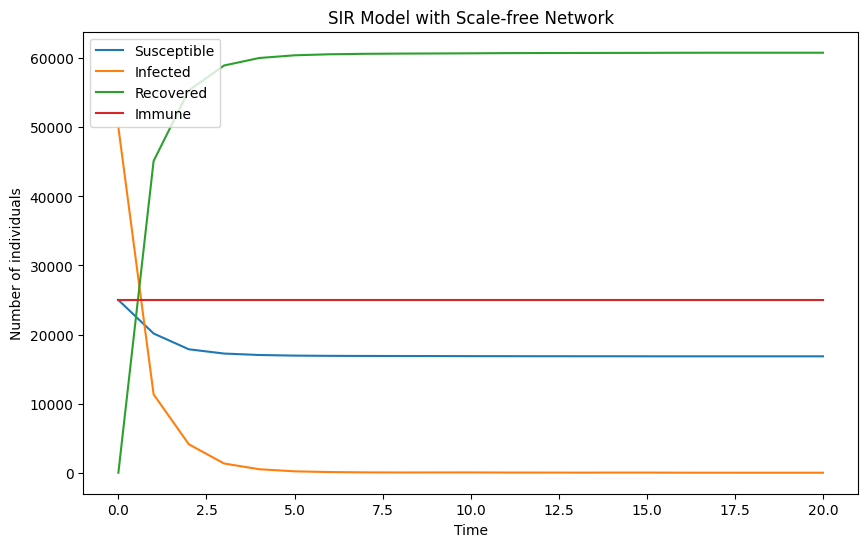

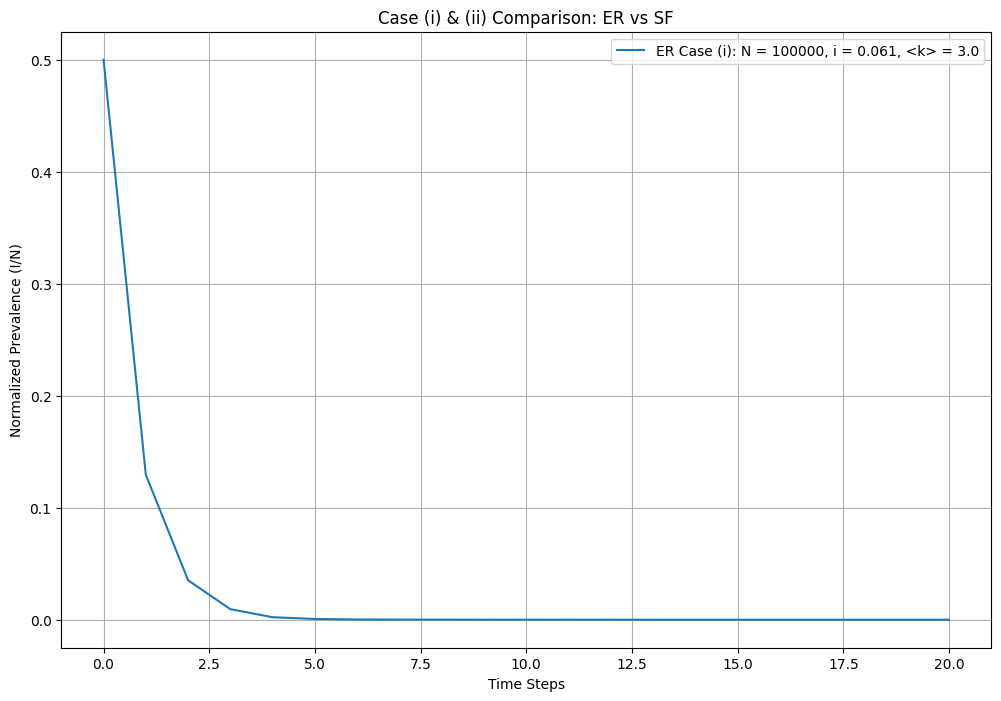

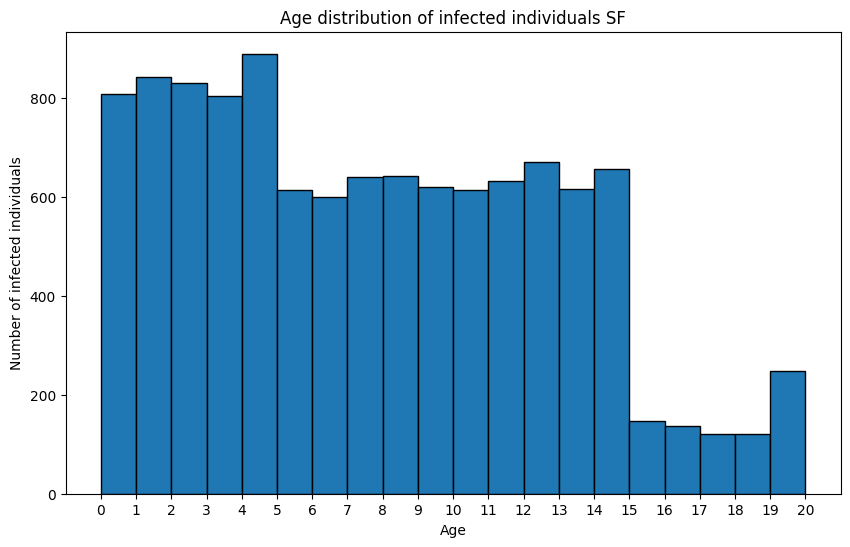

In [5]:
# Scale-free network

def Imm_sf(N, i, k, initial_infected, timesteps, gamma, age, initial_age, immune_count):
    # Generate a sequence of expected degrees with a power-law distribution
    s = nx.utils.powerlaw_sequence(N, gamma)
    # Rescale the expected degrees to match the given average degree
    s = np.array(s) * k / np.mean(s)
    # Generate the scale-free network
    G = nx.expected_degree_graph(s, selfloops=False)

    ages = {node: np.random.choice(age) for node in G.nodes()}

    # Initialize the infection
    # initial_infected = np.random.choice(G.nodes(), size=int(N * initial_infected_fraction), replace=False)
    
    infected = set()
    for age_group, fraction in initial_age.items():
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # size = min(int(fraction * initial_infected), len(age_group_nodes))
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)
    
    non_infected = set(G.nodes()) - infected
    Immune = set(np.random.choice(list(non_infected), size=int(len(non_infected)*immune_count), replace=False))
    susceptible = non_infected - Immune
    recovered = set()
    
    # Record the prevalence over time
    S = [len(susceptible)]
    I = [len(infected)]
    R = [len(recovered)]
    IM = [len(Immune)]
    prevalence = [len(infected) / N]
    infected_ages = []

    # Simulate the spread over time
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()
        
        for node in set(infected):
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                elif neighbor in Immune and np.random.random() < immune_rate:
                    new_infected.add(neighbor)
                
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)
                
        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        IM.append(len(Immune))
        prevalence.append(len(infected) / N)
        new_infected_ages = [ages[node] for node in new_infected]
        infected_ages.append(new_infected_ages)

    return S, I, R, IM, prevalence, infected_ages

# Parameters for the simulations
gamma = 2.5

# Run simulations for the scale-free network for case (i)
SfI, IfI, RfI, Imf,  _, i_ageI = Imm_sf(N, i_1, k_1, initial_infected, timesteps, gamma, age, initial_age, immune_count)
prevalence_sf_Im = []
i_ageI = [age for ages in i_ageI for age in ages]

for _ in range(simulations):
    _, _, _, _, preva_sf_Im, _ = Imm_sf(N, i_1, k_1, initial_infected, timesteps, gamma, age, initial_age, immune_count)
    prevalence_sf_Im.append(preva_all_Im)

avg_prevalence_sf_Im = np.mean(prevalence_sf_Im, axis=0)

# Plot SIR
plt.figure(figsize=(10, 6))
plt.plot(SfI, label='Susceptible')
plt.plot(IfI, label='Infected')
plt.plot(RfI, label='Recovered')
plt.plot(Imf, label='Immune')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIR Model with Scale-free Network')
plt.show()

# Plotting the results for comparison
plt.figure(figsize=(12, 8))
plt.plot(avg_prevalence_sf_Im, label=f'ER Case (i): N = {N}, i = {i_1}, <k> = {k_1}')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Prevalence (I/N)')
plt.title('Case (i) & (ii) Comparison: ER vs SF')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(i_ageI, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals SF')
plt.xticks(range(0, 21))
plt.show()


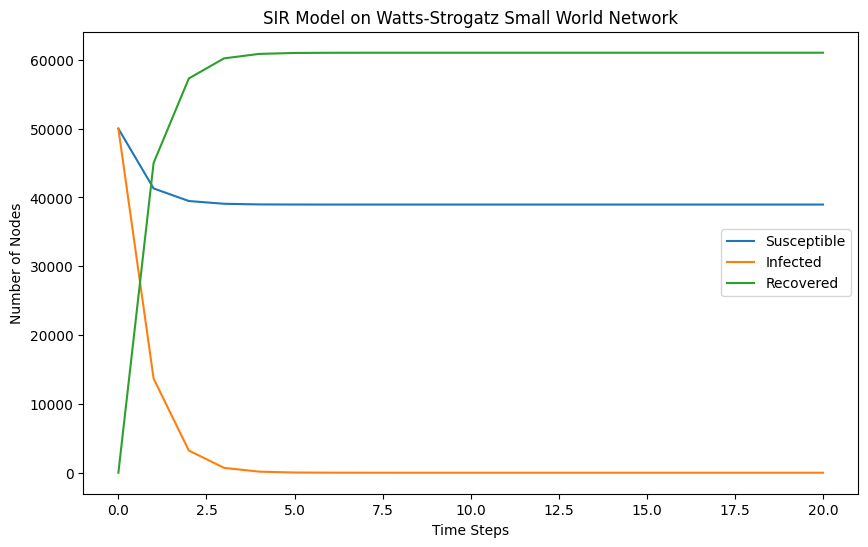

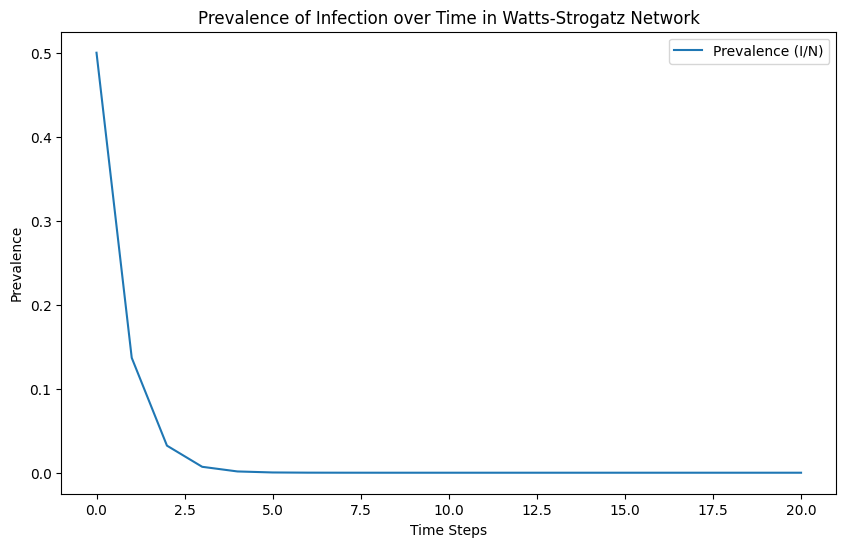

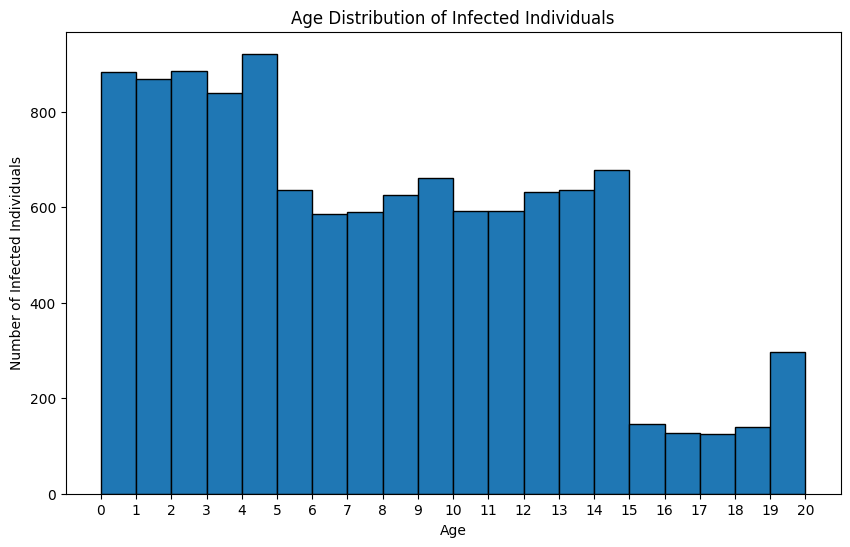

In [6]:
# Small World Network

def sir_model_watts_strogatz(N, k, p, i, r, initial_infected, timesteps, age_distribution, initial_age):
    G = nx.watts_strogatz_graph(N, int(k), int(p))

    # Assign ages to each node
    ages = {node: np.random.choice(age_distribution) for node in G.nodes()}

    # Initialize the infection
    # infected = set(np.random.choice(list(G.nodes()), size=initial_infected, replace=False))
    infected = set()
    for age_group, fraction in initial_age.items():
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # size = min(int(fraction * initial_infected), len(age_group_nodes))
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)
    
    susceptible = set(G.nodes()) - infected
    recovered = set()

    S, I, R = [len(susceptible)], [len(infected)], [len(recovered)]
    prevalence = [len(infected) / N]
    infected_ages = []

    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()

        for node in infected.copy():
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                    infected_ages.append(ages[neighbor])

        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        prevalence.append(len(infected) / N)

    return S, I, R, prevalence, infected_ages

# Parameters
p = k_1 / (N - 1)
timesteps = 20
age_distribution = range(0, 21)  # Assuming ages are integers from 0 to 20

# Run the model
Ssm, Ism, Rsm, prevalence_sm, infected_ages_sm = sir_model_watts_strogatz(N, k_1, p, i_1, r, initial_infected, timesteps, age_distribution, initial_age)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Ssm, label='Susceptible')
plt.plot(Ism, label='Infected')
plt.plot(Rsm, label='Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.legend()
plt.title('SIR Model on Watts-Strogatz Small World Network')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prevalence_sm, label='Prevalence (I/N)')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence')
plt.legend()
plt.title('Prevalence of Infection over Time in Watts-Strogatz Network')
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(infected_ages_sm, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Infected Individuals')
plt.title('Age Distribution of Infected Individuals')
plt.xticks(range(0, 21))
plt.show()

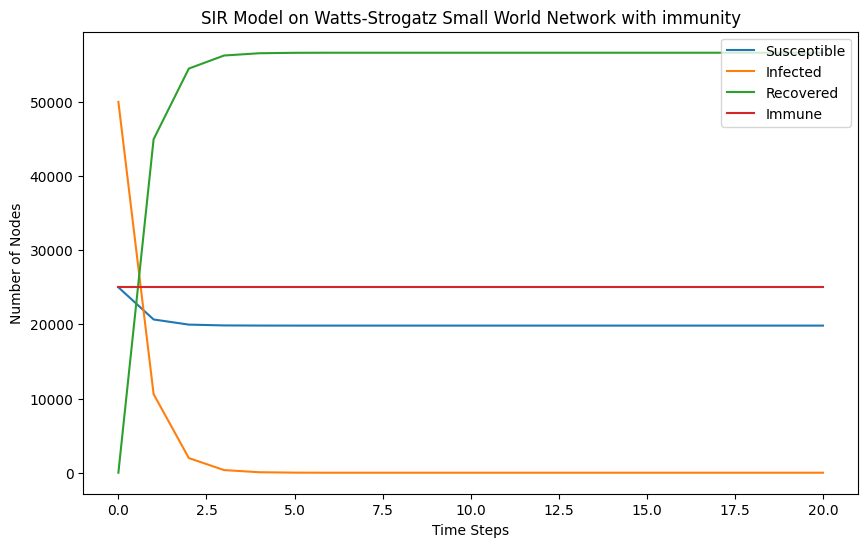

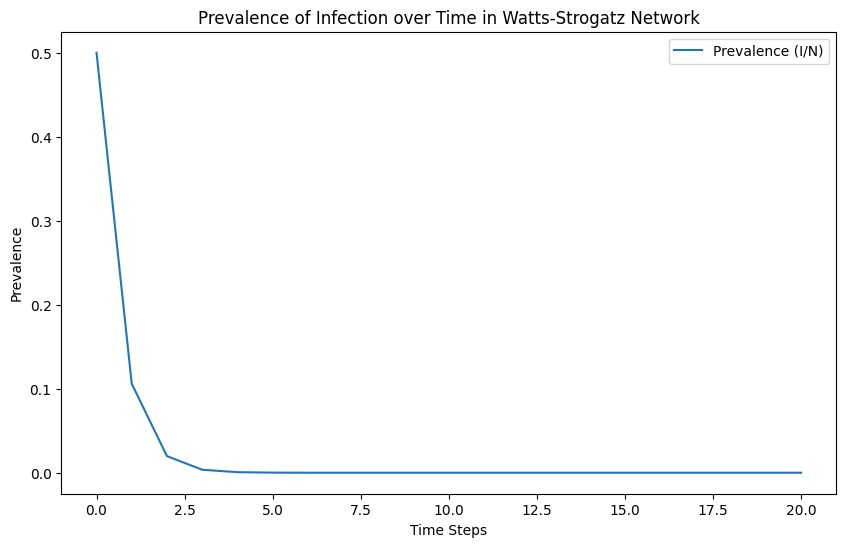

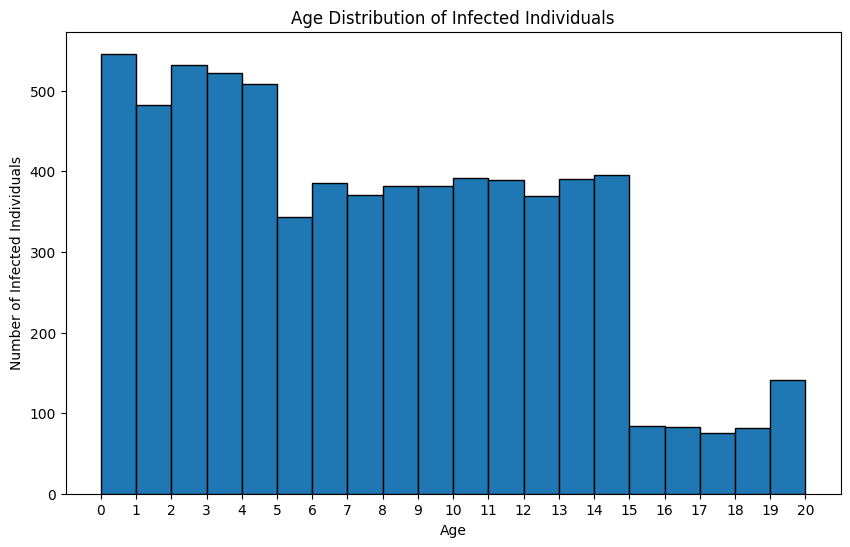

In [7]:
# Small World Network with immunity

def sir_model_watts_strogatz(N, k, p, i, r, initial_infected, timesteps, age_distribution, initial_age, immune_count):
    G = nx.watts_strogatz_graph(N, int(k), int(p))

    # Assign ages to each node
    ages = {node: np.random.choice(age_distribution) for node in G.nodes()}

    # Initialize the infection
    # infected = set(np.random.choice(list(G.nodes()), size=initial_infected, replace=False))
    infected = set()
    for age_group, fraction in initial_age.items():
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # size = min(int(fraction * initial_infected), len(age_group_nodes))
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)
    
    non_infected = set(G.nodes()) - infected
    Immune = set(np.random.choice(list(non_infected), size=int(len(non_infected)*immune_count), replace=False))
    susceptible = non_infected - Immune
    recovered = set()

    S, I, R, IM = [len(susceptible)], [len(infected)], [len(recovered)], [len(Immune)]
    prevalence = [len(infected) / N]
    infected_ages = []

    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()

        for node in infected.copy():
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                    infected_ages.append(ages[neighbor])
                elif neighbor in Immune and np.random.random() < immune_rate:
                    new_infected.add(neighbor)
                    infected_ages.append(ages[neighbor])

        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        IM.append(len(Immune))
        prevalence.append(len(infected) / N)

    return S, I, R, IM, prevalence, infected_ages

# Parameters
p = k_1 / (N - 1)
timesteps = 20
age_distribution = range(0, 21)  # Assuming ages are integers from 0 to 20

# Run the model
Ssm, Ism, Rsm, Ims, prevalence_sm, infected_ages_sm = sir_model_watts_strogatz(N, k_1, p, i_1, r, initial_infected, timesteps, age_distribution, initial_age, immune_count)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Ssm, label='Susceptible')
plt.plot(Ism, label='Infected')
plt.plot(Rsm, label='Recovered')
plt.plot(Ims, label='Immune')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.legend()
plt.title('SIR Model on Watts-Strogatz Small World Network with immunity')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prevalence_sm, label='Prevalence (I/N)')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence')
plt.legend()
plt.title('Prevalence of Infection over Time in Watts-Strogatz Network')
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(infected_ages_sm, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Infected Individuals')
plt.title('Age Distribution of Infected Individuals')
plt.xticks(range(0, 21))
plt.show()

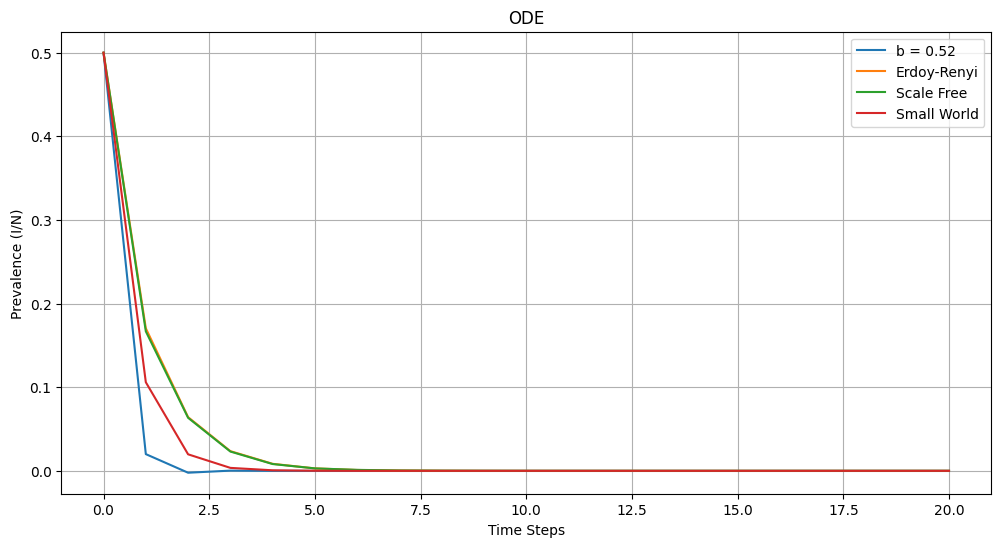

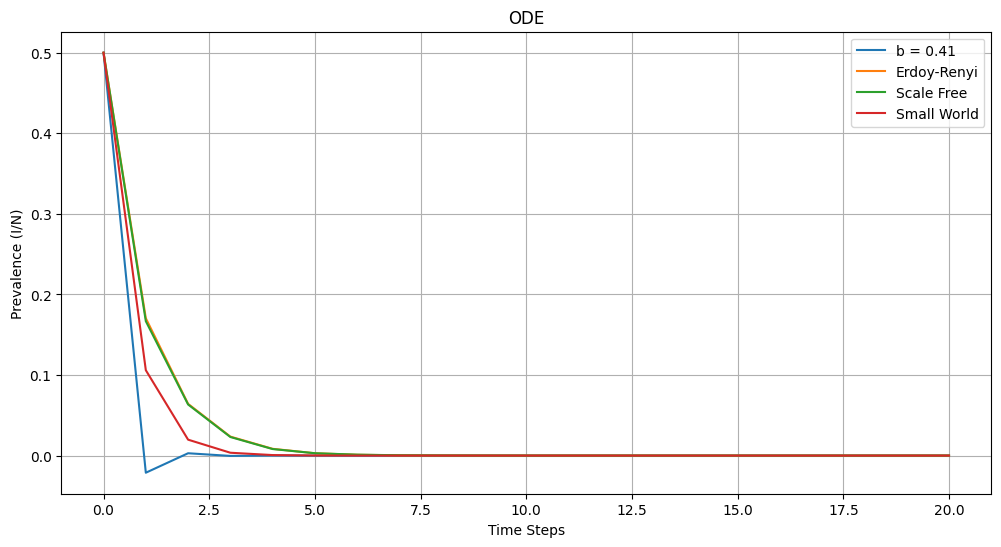

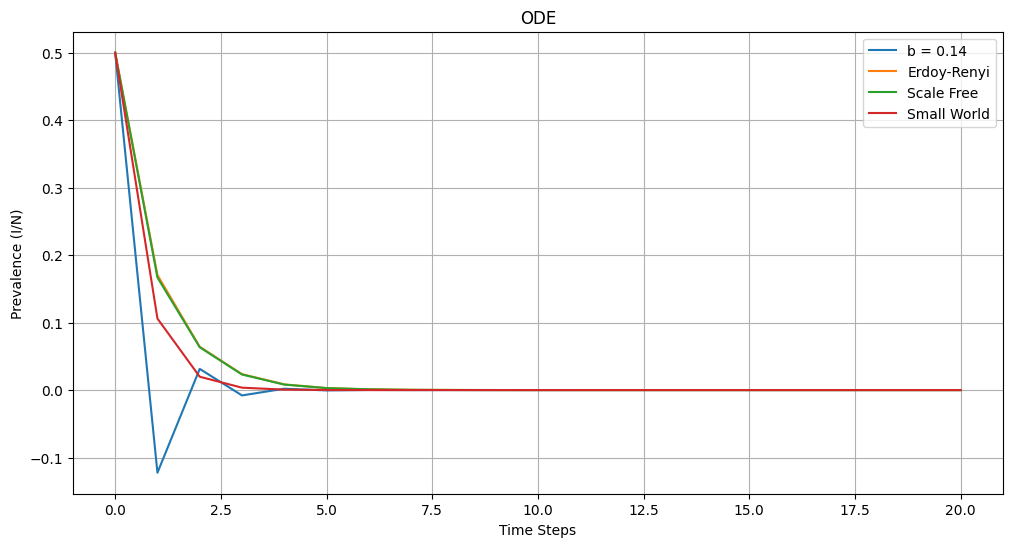

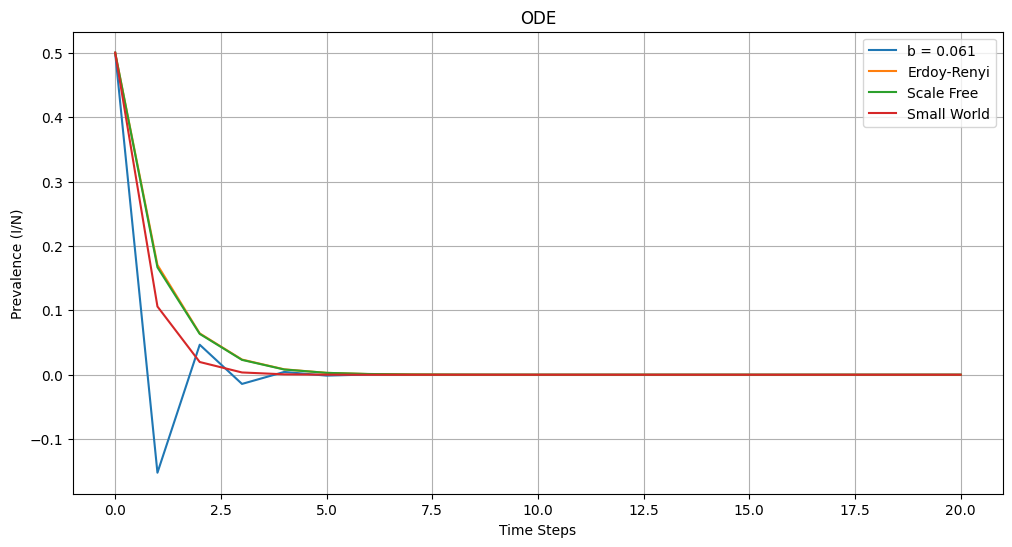

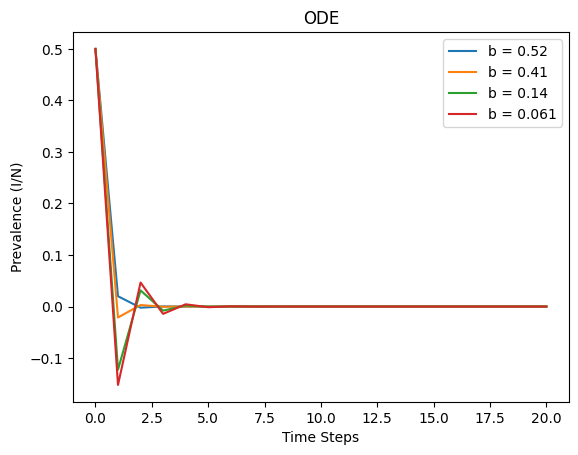

In [58]:
# Euler Method ODE 
# alter the Euler method to solve the SIR model
def euler_si_model(N, b, g, I0, S0, R0, dt, timesteps):
    # Initialize arrays to store the values of I and S over time
    I = np.zeros(timesteps + 1)
    S = np.zeros(timesteps + 1)
    R = np.zeros(timesteps + 1)

    I[0] = I0
    S[0] = S0
    R[0] = R0
    
    # the Euler method to solve the ODEs
    for t in range(1, timesteps + 1):
        dIdt = b * (I[t-1] * S[t-1])/N - g * I[t-1]
        dSdt = -b * (I[t-1] * S[t-1])/N
        dRdt = g * I[t-1]
        
        I[t] = I[t-1] + dIdt * dt
        S[t] = S[t-1] + dSdt * dt
        R[t] = R[t-1] + dRdt * dt
    
    return S, I, R

# Parameters
# Transmission probability for case (i)
# b = {(0-4) : 0.52, 
#      (5-10) : 0.41, 
#      (10-15) : 0.14, 
#      (15-20) : 0.061}
b = [0.52, 0.41, 0.14, 0.061]
g = 0.9

# Initial number of infected individuals
I0 = 0.5 * N 
# Initial number of susceptible individuals 
S0 = N - I0    
# Initial number of recovered individuals
R0 = 0

dt = 1.5  

# Execution of the ODE
S_ode, I_ode, R_ode = [], [], []
for rate in b:
    So, Io, Ro = euler_si_model(N, rate, g, I0, S0, R0, dt, timesteps)
    S_ode.append(So)
    I_ode.append(Io/N)
    R_ode.append(Ro)

for i in range(len(b)):
    plt.figure(figsize=(12, 6))
    plt.plot(I_ode[i], label=f'b = {b[i]}')
    plt.plot(avg_prevalence, label=f'Erdoy-Renyi')
    plt.plot(avg_prevalence_sf, label=f'Scale Free')
    plt.plot(prevalence_sm, label='Small World')
    plt.xlabel('Time Steps')
    plt.ylabel('Prevalence (I/N)')
    plt.title('ODE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results of the ODE simulations
for i in range(len(b)):
    plt.plot(I_ode[i], label=f'b = {b[i]}')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Prevalence (I/N)')
    plt.title('ODE')

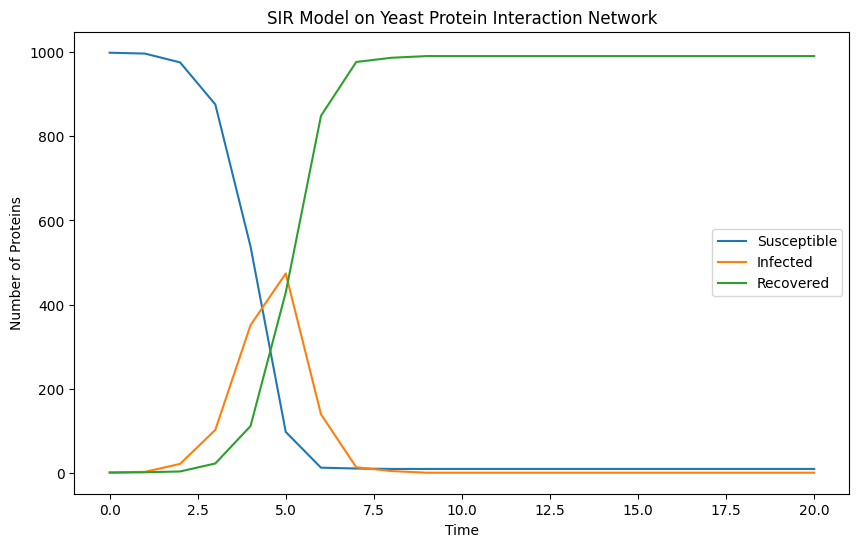

In [9]:
def sir_model(network, initial_infected, infection_rate, recovery_rate, timesteps):
    susceptible = set(network.nodes()) - set(initial_infected)
    infected = set(initial_infected)
    recovered = set()

    S, I, R = [len(susceptible)], [len(infected)], [len(recovered)]

    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()

        for node in infected:
            for neighbor in network.neighbors(node):
                if neighbor in susceptible and np.random.random() < infection_rate:
                    new_infected.add(neighbor)

            if np.random.random() < recovery_rate:
                new_recovered.add(node)

        infected -= new_recovered
        infected |= new_infected
        susceptible -= new_infected
        recovered |= new_recovered

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))

    return S, I, R

# generate a random scale-free network
yeast_network = nx.barabasi_albert_graph(1000, 2)  # 1000 nodes and each new node attaches to 2 existing nodes

# Define the initial set of infected nodes
initial_infected = {np.random.choice(yeast_network.nodes())}

# Define infection and recovery rates
# Probability of a susceptible protein being 'infected' by an infected neighbor
infection_rate = 0.9  
# Probability of an infected protein 'recovering' and becoming resistant to infection
recovery_rate = 0.9  

# Run the SIR model
S, I, R = sir_model(yeast_network, initial_infected, infection_rate, recovery_rate, 20)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of Proteins')
plt.legend()
plt.title('SIR Model on Yeast Protein Interaction Network')
plt.show()